In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import statsmodels.api as sm
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve

In [8]:
df = pd.read_csv('Advertising.csv', index_col=0)
df

,TV,radio,newspaper,sales
1,230.1,37.8,69.2,22.1
2,44.5,39.3,45.1,10.4
3,17.2,45.9,69.3,9.3
4,151.5,41.3,58.5,18.5
5,180.8,10.8,58.4,12.9
...,...,...,...,...
196,38.2,3.7,13.8,7.6
197,94.2,4.9,8.1,9.7
198,177.0,9.3,6.4,12.8
199,283.6,42.0,66.2,25.5


In [10]:
# Regresión lineal simple
y = df['sales']
x = df.drop(columns=['sales'])
X = sm.add_constant(x)

model_lin = sm.OLS(y, X).fit()
model_lin.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  sales   R-squared:                       0.897
Model:                            OLS   Adj. R-squared:                  0.896
Method:                 Least Squares   F-statistic:                     570.3
Date:                Thu, 04 Dec 2025   Prob (F-statistic):           1.58e-96
Time:                        16:11:58   Log-Likelihood:                -386.18
No. Observations:                 200   AIC:                             780.4
Df Residuals:                     196   BIC:                             793.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.9389      0.312      9.422      0.000       2.324       3.554
TV             0.0458      0.001     32.809      0.000       0.043       0.049
radio          0.1885      0.009     21.893      0.000       0.172       0.206
newspaper     -0.0010      0.006     -0.177      0.860      -0.013       0.011
==============================================================================
Omnibus:                       60.414   Durbin-Watson:                   2.084
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              151.241
Skew:                          -1.327   Prob(JB):                     1.44e-33
Kurtosis:                       6.332   Cond. No.                         454.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [11]:
# Guardar las variables para despues
y_pred_lin = model_lin.predict(X)

rmse_lin = mean_squared_error(y, y_pred_lin, squared=False)
r2_lin = r2_score(y, y_pred_lin)

print(f"RMSE lineal original: {rmse_lin:.3f}")
print(f"R2 lineal original  : {r2_lin:.3f}")

RMSE lineal original: 1.669
R2 lineal original  : 0.897


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


---
## Regresión con XGBoost

In [18]:
from xgboost import XGBRegressor

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.4, random_state=42
)

xgb_base = XGBRegressor(
    objective="reg:squarederror",
    n_estimators=300,
    learning_rate=0.1,
    max_depth=3,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

xgb_base.fit(X_train, y_train)

y_pred_train_xgb = xgb_base.predict(X_train)
y_pred_test_xgb  = xgb_base.predict(X_test)

print("XGBoost base ")
print(f"RMSE train: {mean_squared_error(y_train, y_pred_train_xgb, squared=False):.4f}")
print(f"RMSE test: {mean_squared_error(y_test,  y_pred_test_xgb,  squared=False):.4f}")
print(f"R2 train: {r2_score(y_train, y_pred_train_xgb):.3f}")
print(f"R2 test: {r2_score(y_test,  y_pred_test_xgb):.3f}")

XGBoost base 
RMSE train: 0.0492
RMSE test: 0.8447
R2 train: 1.000
R2 test: 0.972


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [14]:
# XGBoost optimizado
param_grid_xgb = {
    "n_estimators": [200, 400],
    "max_depth": [2, 3, 4],
    "learning_rate": [0.05, 0.1],
    "subsample": [0.8, 1.0],
    "colsample_bytree": [0.8, 1.0]
}

xgb_reg = XGBRegressor(
    objective="reg:squarederror",
    random_state=42
)

grid_xgb = GridSearchCV(
    xgb_reg,
    param_grid_xgb,
    cv=5,
    scoring="neg_mean_squared_error",
    n_jobs=-1
)

grid_xgb.fit(X_train, y_train)

print("Mejores hiperparámetros (dataset original):")
print(grid_xgb.best_params_)

Mejores hiperparámetros (dataset original):
{'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}


In [19]:
best_xgb = grid_xgb.best_estimator_

y_pred_train_xgb_best = best_xgb.predict(X_train)
y_pred_test_xgb_best  = best_xgb.predict(X_test)

print("XGBoost optimizado")
print(f"RMSE train: {mean_squared_error(y_train, y_pred_train_xgb_best, squared=False):.4f}")
print(f"RMSE test: {mean_squared_error(y_test,  y_pred_test_xgb_best,  squared=False):.4f}")
print(f"R2 train: {r2_score(y_train, y_pred_train_xgb_best):.3f}")
print(f"R2 test: {r2_score(y_test,  y_pred_test_xgb_best):.3f}")

XGBoost optimizado
RMSE train: 0.0817
RMSE test: 0.7356
R2 train: 1.000
R2 test: 0.979


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


---
### 6 Problemas potenciales

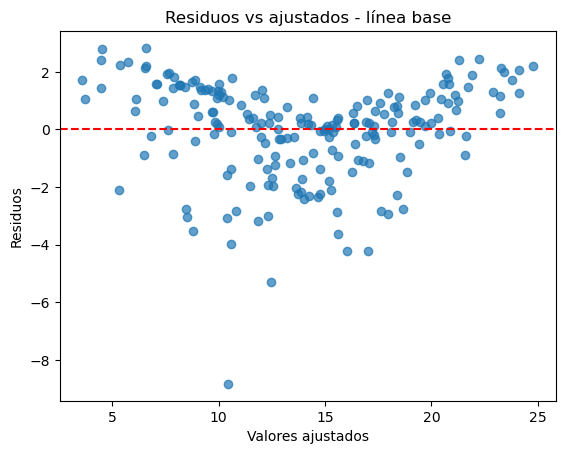

In [17]:
# No linealidad
resid = model_lin.resid
fitted = model_lin.fittedvalues

plt.scatter(fitted, resid, alpha=0.7)
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("Valores ajustados")
plt.ylabel("Residuos")
plt.title("Residuos vs ajustados - línea base")
plt.show()

In [20]:
# Correlación de los errores
from statsmodels.stats.stattools import durbin_watson

dw = durbin_watson(resid)
print(f"Durbin-Watson: {dw:.3f}")

Durbin-Watson: 2.084


In [21]:
# Varianza no constante
import statsmodels.stats.diagnostic as smd

bp_test = smd.het_breuschpagan(resid, X)
bp_stat, bp_pvalue = bp_test[0], bp_test[1]

print(f"Breusch-Pagan stat: {bp_stat:.3f}, p-value: {bp_pvalue:.3f}")

Breusch-Pagan stat: 5.133, p-value: 0.162


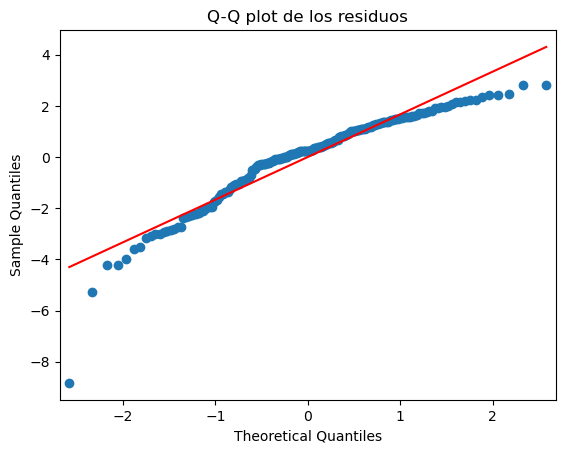

In [22]:
# Normalidad de los errores
sm.qqplot(resid, line="s")
plt.title("Q-Q plot de los residuos")
plt.show()

In [23]:
# Outliers
influence = model_lin.get_influence()
standard_resid = influence.resid_studentized_internal

# Ver valores con residuo estandarizado alto
outlier_idx = np.where(np.abs(standard_resid) > 3)[0]
outlier_idx, standard_resid[outlier_idx]

(array([  5, 130]), array([-3.20870472, -5.33683837]))

In [35]:
# Puntos palanca
leverage = influence.hat_matrix_diag
print("Leverage máximo:", leverage.max())

Leverage máximo: 0.0863341382518808


---
### Conclusión

* Con la gráfica de residuos vs ajustados podemos ver que no hay linealidad en los datos. Con fijarnos en la forma de U que tienen los datos podemos darnos cuenta
* Con la prueba Durbin-Watson podemos ver que el valor que nos arroja nos dice que no hay correlación en los errores
* También podemos ver que no hay heterocedasticidad
* Con el q-q plot podemos ver que no hay normalidad de los errores
* También podemos ver que hay 2 outliers, por ahorita los vamos a dejar y luego vamos a tratar con ellos para ver si mejora el modelo
*también podemos ver que hay un punto palanca alto, al igual que con el outlier por ahorita lo vamos a dejar
*

---
### Modificación del dataset

**Eiminar Newspaper:** Lo vamos a quitar debido a las siguientes razones
* p-value = 0.86
* No aporta nada
* Introduce ruido
* No mejora predicción
* Quitarla mejora la estabilidad del modelo

**Agregar polinomios:** vamos a agregar polinomios para arreglar la no linealidad que exite en los datos

**Agregar una interacción entre variables:** Voy a agregar una interacción entre TV y Radio

In [26]:
df_mod = df.copy()
df_mod["TV_radio"] = df["TV"] * df["radio"]
df_mod["TV2"] = df["TV"]**2
df_mod["radio2"] = df["radio"]**2
df_mod = df_mod.drop(columns=["newspaper"])
df_mod

,TV,radio,sales,TV_radio,TV2,radio2
1,230.1,37.8,22.1,8697.78,52946.01,1428.84
2,44.5,39.3,10.4,1748.85,1980.25,1544.49
3,17.2,45.9,9.3,789.48,295.84,2106.81
4,151.5,41.3,18.5,6256.95,22952.25,1705.69
5,180.8,10.8,12.9,1952.64,32688.64,116.64
...,...,...,...,...,...,...
196,38.2,3.7,7.6,141.34,1459.24,13.69
197,94.2,4.9,9.7,461.58,8873.64,24.01
198,177.0,9.3,12.8,1646.10,31329.00,86.49
199,283.6,42.0,25.5,11911.20,80428.96,1764.00


In [29]:
x_mod = df_mod.drop(columns=["sales"])
y_mod = df_mod["sales"]
X_mod = sm.add_constant(x_mod)

lr_mod = sm.OLS(y_mod, X_mod).fit()
lr_mod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  sales   R-squared:                       0.986
Model:                            OLS   Adj. R-squared:                  0.986
Method:                 Least Squares   F-statistic:                     2740.
Date:                Thu, 04 Dec 2025   Prob (F-statistic):          8.17e-178
Time:                        16:36:05   Log-Likelihood:                -186.54
No. Observations:                 200   AIC:                             385.1
Df Residuals:                     194   BIC:                             404.9
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.1944      0.206     25.202      0.000       4.788       5.601
TV             0.0510      0.002     22.801      0.000       0.047       0.055
radio          0.0265      0.012      2.136      0.034       0.002       0.051
TV_radio       0.0011   3.48e-05     30.892      0.000       0.001       0.001
TV2           -0.0001    6.9e-06    -15.914      0.000      -0.000   -9.62e-05
radio2         0.0002      0.000      0.789      0.431      -0.000       0.001
==============================================================================
Omnibus:                      170.235   Durbin-Watson:                   2.200
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4115.221
Skew:                          -2.994   Prob(JB):                         0.00
Kurtosis:                      24.400   Cond. No.                     1.81e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.81e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [30]:
y_pred_lin_mod = lr_mod.predict(X_mod)

rmse_lin_mod = mean_squared_error(y_mod, y_pred_lin_mod, squared=False)
r2_lin_mod = r2_score(y_mod, y_pred_lin_mod)

print(f"RMSE lineal modificado: {rmse_lin_mod:.3f}")
print(f"R2 lineal modificado: {r2_lin_mod:.3f}")

RMSE lineal modificado: 0.615
R2 lineal modificado: 0.986


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [31]:
X_train_mod, X_test_mod, y_train_mod, y_test_mod = train_test_split(
    X_mod, y_mod, test_size=0.4, random_state=42
)

xgb_mod = XGBRegressor(
    objective="reg:squarederror",
    n_estimators=300,
    learning_rate=0.1,
    max_depth=3,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

xgb_mod.fit(X_train_mod, y_train_mod)

y_pred_train_mod = xgb_mod.predict(X_train_mod)
y_pred_test_mod  = xgb_mod.predict(X_test_mod)

print("XGBoost base modificado")
print(f"RMSE train: {mean_squared_error(y_train_mod, y_pred_train_mod, squared=False):.4f}")
print(f"RMSE test: {mean_squared_error(y_test_mod,  y_pred_test_mod,  squared=False):.4f}")
print(f"R2 train: {r2_score(y_train_mod, y_pred_train_mod):.4f}")
print(f"R2 test: {r2_score(y_test_mod,  y_pred_test_mod):.4f}")

XGBoost base modificado
RMSE train: 0.0433
RMSE test: 0.6874
R2 train: 0.9999
R2 test: 0.9813


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [32]:
# XGBoost optimizando
param_grid_xgb_mod = {
    "n_estimators": [200, 400],
    "max_depth": [2, 3, 4],
    "learning_rate": [0.05, 0.1],
    "subsample": [0.8, 1.0],
    "colsample_bytree": [0.8, 1.0]
}

xgb_reg_mod = XGBRegressor(objective="reg:squarederror", random_state=42)

grid_xgb_mod = GridSearchCV(
    xgb_reg_mod,
    param_grid_xgb_mod,
    cv=5,
    scoring="neg_mean_squared_error",
    n_jobs=-1
)

grid_xgb_mod.fit(X_train_mod, y_train_mod)

print("Mejores hiperparámetros (modelo modificado):")
print(grid_xgb_mod.best_params_)

Mejores hiperparámetros (modelo modificado):
{'colsample_bytree': 1.0, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 200, 'subsample': 1.0}


In [33]:
best_xgb_mod = grid_xgb_mod.best_estimator_

y_pred_test_best_mod = best_xgb_mod.predict(X_test_mod)

print("=== XGBoost optimizado (modificado) ===")
print(f"RMSE test: {mean_squared_error(y_test_mod, y_pred_test_best_mod, squared=False):.4f}")
print(f"R2 test  : {r2_score(y_test_mod, y_pred_test_best_mod):.4f}")

=== XGBoost optimizado (modificado) ===
RMSE test: 0.6659
R2 test  : 0.9825


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [34]:
# Comparación
print("Comparación de modelos lineales")
print(f"R2 lineal original: {r2_lin:.3f}")
print(f"R2 lineal modificado: {r2_lin_mod:.3f}")
print()
print("Comparación de XGBoost")
print(f"R2 XGBoost original (test): {r2_score(y_test, y_pred_test_xgb_best):.3f}")
print(f"R2 XGBoost modificado (test): {r2_score(y_test_mod, y_pred_test_best_mod):.3f}")

Comparación de modelos lineales
R2 lineal original: 0.897
R2 lineal modificado: 0.986

Comparación de XGBoost
R2 XGBoost original (test): 0.979
R2 XGBoost modificado (test): 0.982


Podemos ver que si mejoro el R2 de los datos modificados, esto se debe a que arreglamos la no linealidad usando polinomios y agregando una interacción, pero para XGBoost podemos ver que la diferencia no es tanta como en el modelo lineal.

El factor principal para que mejorara la regresión fue arreglar lo de no linealidad

---
## Tratar de sacar 10

In [43]:
outliers = [5, 130]
df_no_out = df.drop(index=outliers).reset_index(drop=True)

In [44]:
df_no_out["TV_radio"] = df_no_out["TV"] * df_no_out["radio"]
df_no_out["TV2"] = df_no_out["TV"]**2
df_no_out["radio2"] = df_no_out["radio"]**2
df_no_out = df_no_out.drop(columns=["newspaper"])

x_no_out = df_no_out.drop(columns=["sales"])
y_no_out = df_no_out["sales"]

X_no_out = sm.add_constant(x_no_out)
model_no_out = sm.OLS(y_no_out, X_no_out).fit()
model_no_out.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  sales   R-squared:                       0.986
Model:                            OLS   Adj. R-squared:                  0.986
Method:                 Least Squares   F-statistic:                     2726.
Date:                Thu, 04 Dec 2025   Prob (F-statistic):          3.51e-176
Time:                        16:56:49   Log-Likelihood:                -184.79
No. Observations:                 198   AIC:                             381.6
Df Residuals:                     192   BIC:                             401.3
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.1711      0.207     24.977      0.000       4.763       5.580
TV             0.0512      0.002     22.793      0.000       0.047       0.056
radio          0.0267      0.012      2.148      0.033       0.002       0.051
TV_radio       0.0011   3.49e-05     30.715      0.000       0.001       0.001
TV2           -0.0001   6.92e-06    -15.910      0.000      -0.000   -9.64e-05
radio2         0.0002      0.000      0.821      0.413      -0.000       0.001
==============================================================================
Omnibus:                      169.113   Durbin-Watson:                   2.145
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4093.433
Skew:                          -3.000   Prob(JB):                         0.00
Kurtosis:                      24.452   Cond. No.                     1.82e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.82e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [45]:
y_pred_no_out = model_no_out.predict(X_no_out)

rmse_no_out = mean_squared_error(y_no_out, y_pred_no_out, squared=False)
r2_no_out = r2_score(y_no_out, y_pred_no_out)

print(f"RMSE sin outliers: {rmse_no_out:.4f}")
print(f"R2 sin outliers: {r2_no_out:.4f}")

RMSE sin outliers: 0.6153
R2 sin outliers: 0.9861


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


No cambia mucho si quitamos el outlier entonces lo vamos a dejar

---

In [47]:
# Con transformaciones logaritmicas
df_log = df.copy()

df_log["log_TV"] = np.log(df_log["TV"] + 1)
df_log["log_radio"] = np.log(df_log["radio"] + 1)
df_log["log_newspaper"] = np.log(df_log["newspaper"] + 1)
df_log["log_sales"] = np.log(df_log["sales"] + 1)

# X y Y
x_log = df_log[["log_TV", "log_radio", "log_newspaper"]]
y_log = df_log["log_sales"]

X_log = sm.add_constant(x_log)
model_log = sm.OLS(y_log, X_log).fit()
model_log.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_sales   R-squared:                       0.938
Model:                            OLS   Adj. R-squared:                  0.937
Method:                 Least Squares   F-statistic:                     983.6
Date:                Thu, 04 Dec 2025   Prob (F-statistic):          7.71e-118
Time:                        17:00:00   Log-Likelihood:                 190.46
No. Observations:                 200   AIC:                            -372.9
Df Residuals:                     196   BIC:                            -359.7
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.5205      0.043     11.968      0.000       0.435       0.606
log_TV            0.3280      0.007     47.161      0.000       0.314       0.342
log_radio         0.1876      0.008     24.849      0.000       0.173       0.202
log_newspaper     0.0135      0.008      1.715      0.088      -0.002       0.029
==============================================================================
Omnibus:                       27.667   Durbin-Watson:                   1.938
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              110.636
Skew:                           0.395   Prob(JB):                     9.45e-25
Kurtosis:                       6.557   Cond. No.                         42.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

R2 baja entonces no me sirve

---

In [52]:
# Con polinomial features
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

X_base = df[["TV", "radio", "newspaper"]]
y_base = df["sales"]

poly = PolynomialFeatures(degree=4, include_bias=False)
X_poly = poly.fit_transform(X_base)
model_poly = LinearRegression()
model_poly.fit(X_poly, y_base)

y_pred_poly = model_poly.predict(X_poly)

rmse_poly = mean_squared_error(y_base, y_pred_poly, squared=False)
r2_poly = r2_score(y_base, y_pred_poly)

print(f"RMSE modelo polinómico: {rmse_poly:.4f}")
print(f"R2 modelo polinómico  : {r2_poly:.4f}")

RMSE modelo polinómico: 0.3778
R2 modelo polinómico  : 0.9947


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Usando polinomial features me dio el mejor R2 con polinomios de grado 4

Este fue el modelo que mejor R2 me dio

---